# Job Salary Prediction
This is a quick notebook detailing a model I built for a Kaggle competition from 2013 where Adzuna asked entrants to predict job salaries based on a dataset they supplied. This is the first model I have built which relies solely on text data which provided a good experience for working on messy data that required a lot of feature engineering.

The first few rows of the DataFrame are displayed below with summary statistics. SalaryNormalized is the variable to be predicted.

# Job Salary Prediction
This is a quick notebook detailing a model I built for a Kaggle competition from 2013 where Adzuna asked entrants to predict job salaries based on a dataset they supplied. This is the first model I have built which relies solely on text data which provided a good experience for working on messy data that required a lot of feature engineering.

The first few rows of the DataFrame are displayed below with summary statistics. SalaryNormalized is the variable to be predicted.

In [ ]:
df.head()

,Id,Title,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryNormalized,SourceName
0,12612628,Engineering Systems Analyst,Dorking,NaN,permanent,Gregory Martin International,Engineering Jobs,25000,cv-library.co.uk
1,12612830,Stress Engineer Glasgow,Glasgow,NaN,permanent,Gregory Martin International,Engineering Jobs,30000,cv-library.co.uk
2,12612844,Modelling and simulation analyst,Hampshire,NaN,permanent,Gregory Martin International,Engineering Jobs,30000,cv-library.co.uk
3,12613049,Engineering Systems Analyst / Mathematical Modeller,Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,27500,cv-library.co.uk
4,12613647,"Pioneer, Miser Engineering Systems Analyst",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,25000,cv-library.co.uk


In [ ]:
## ContractType and ContractTime features have a lot of missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244768 entries, 0 to 244767
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   Id                  244768 non-null  int64 
 1   Title               244767 non-null  object
 2   FullDescription     244768 non-null  object
 3   LocationNormalized  244768 non-null  object
 4   ContractType        65442 non-null   object
 5   ContractTime        180863 non-null  object
 6   Company             212338 non-null  object
 7   Category            244768 non-null  object
 8   SalaryNormalized    244768 non-null  int64 
 9   SourceName          244767 non-null  object
dtypes: int64(2), object(8)
memory usage: 18.7+ MB


# Baseline Model
First I test what level of accuracy we can expect on a baseline model so I have a benchmark to compare future models to and evaluate their relative performance.

This baseline model predicts the salary of every record to be the average salary of the whole dataset.
The Kaggle competition is judged using Mean Absolute Error (MAE), so that's what I'm using as my metric across all models
###Baseline model produces a MAE of 13,399.6



In [ ]:
# Baseline Model
baseline = np.ones(len(df['SalaryNormalized'])) * df['SalaryNormalized'].mean()
mean_absolute_error(df['SalaryNormalized'], baseline)

13399.57843160822

Next I test what kind of accuracy can be achieved simply by feeding a model the raw data.

I use a RandomForest because they consistently perform well on most datasets. Later on I will use a Neural Network as well.

I'm using some features of the fast.ai library to encode categorical variables and easily arrange the data to feed into the models.

In [ ]:
def splitter(df, split=0.2): ## Train/test splitting function
  rand_idx = list(torch.randperm(len(df)).numpy())
  cut = int(split * len(df))
  return rand_idx[cut:],rand_idx[:cut]
splits = splitter(df)

procs = [Categorify] # Encodes the categorical features
dep_var = 'SalaryNormalized' # Specify dependent variable
cat_vars = ['Title', 'FullDescription', 'LocationNormalized', 'ContractType', 'ContractTime', 'Company', 'Category', 'SourceName']
to = TabularPandas(df, procs, cat_vars, y_names = dep_var, splits=splits)

xs, y = to.train.xs, to.train.y
valid_xs, valid_y = to.valid.xs, to.valid.y

In [ ]:
def forest(xs, y, n_estimators=40, max_samples=175_000, min_samples_leaf=5):
  return RandomForestRegressor(n_estimators=n_estimators, max_samples=max_samples, min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

naive_model = forest(xs, y)
naive_model_preds = naive_model.predict(xs)

In [ ]:
#collapse-hide
nm_train_score = mean_absolute_error(y, naive_model_preds)
nm_valid_score = mean_absolute_error(valid_y, naive_model.predict(valid_xs))
print('The Naive Model scored a MAE of {} on the training data and {} on the validation data.'.format(nm_train_score, nm_valid_score))

The Naive Model scored a MAE of 6249.058199242024 on the training data and 8584.078321490439 on the validation data.


### The RandomForest performed much better than the baseline model and has less than half the error rate when evaluated on the test set.

### The cardinality of the ```Title``` feature is very high (135,436 unique values, which is about 55% of the dataset). This is because one job title, such as Systems Engineer, is represented in the dataset in many additional ways that don't carry much extra meaning or can be represented using other features (e.g. 'Systems Engineer London' or 'Engineering, Systems'). 

### To resolve this I will scrape the most common words from the job titles and assign them to each record. This should improve the model's accuracy by having considerably more records belonging to fewer, but much more predictively important titles such as Engineer, Teacher, Chef.

In [ ]:
df['Title'].nunique()

135436

The 15 most common words in the job titles are shown below. 'London' has made the list which means locations are fairly prevalent in the job title. However since I already have a location feature, I will remove them from this list.

You can also see that positions of seniority (e.g. Manager, Senior, Executive) are also very common. After experimenting with a few different combinations of features on different models, I found that splitting position seniority out into it's own feature improved the accuracy. This makes sense intuitively that having one feature to describe the role (Electrical Engineer, Software Developer) and another feature to adjust each roles seniority level would yield better results.

In [ ]:
job_word_dict[:15]

[('Manager', 45109),
 ('Engineer', 22161),
 ('Sales', 17096),
 ('Senior', 15925),
 ('Developer', 11914),
 ('Assistant', 10995),
 ('Business', 9296),
 ('Executive', 8954),
 ('Analyst', 8387),
 ('Consultant', 8153),
 ('London', 8073),
 ('Support', 7729),
 ('Project', 6814),
 ('Nurse', 6440),
 ('Development', 6396)]

In [ ]:
def findWholeWord(w):
    return re.compile(r'\b({0})\b'.format(w), flags=re.IGNORECASE).search

def map_function(x):
    result = []
    for key in seniority_level:
        if findWholeWord(key)(x):
          match = findWholeWord(key)(x)
          if match.group().lower() not in result:
            result.append(match.group().lower())
        else:
          continue
    return ' '.join(result)

df['seniority'] = df.Title.apply(map_function)

###Ten most common seniority positions in the data

In [ ]:
df['seniority'].value_counts().head(10)

                     134846
manager               40354
senior                12374
assistant              8360
executive              8156
advisor                4088
worker                 3493
head                   3420
coordinator            2790
manager assistant      2619
Name: seniority, dtype: int64

In [ ]:
def map_function(x):
    result = []
    for word in job_words:
        if findWholeWord(word)(x):
          match = findWholeWord(word)(x)
          if match.group().lower() not in result:
            result.append(match.group().lower())
        else:
          continue
    return ' '.join(result)

df['job_words'] = df.Title.apply(map_function)

### 15 most common job word combinations in the data

In [ ]:
df['job_words'].value_counts().head(15)

                          13022
sales                      3065
engineer                   2018
project                    1818
business development       1808
account                    1448
marketing                  1251
consultant recruitment     1192
administrator              1054
developer                  1027
finance                    1019
teacher                     942
accountant management       919
care                        871
surveyor quantity           856
Name: job_words, dtype: int64

### Prepare the data and load it into the RandomForest model

In [ ]:
procs = [Categorify]
dep_var = 'SalaryNormalized'
cat_vars = ['LocationNormalized', 'ContractType', 'ContractTime', 'Category', 'Company', 'SourceName', 'seniority', 'job_words']
to = TabularPandas(df, procs, cat_vars, y_names = dep_var, splits=splits)
xs, y = to.train.xs, to.train.y
valid_xs, valid_y = to.valid.xs, to.valid.y

rf_model = forest(xs, y);

In [ ]:
#collapse-hide
forest_preds = rf_model.predict(xs)
rf_train_score = mean_absolute_error(y, forest_preds)
valid_preds = rf_model.predict(valid_xs)
rf_valid_score = mean_absolute_error(valid_y, valid_preds)
print('The Feature Engineered Model scored a MAE of {} on the training data and {} on the validation data.'.format(rf_train_score, rf_valid_score))

The Feature Engineered Model scored a MAE of 5736.43454654603 on the training data and 7574.226276235397 on the validation data.


The model has a MAE of 7574.2 on the validation set compared to a MAE of 8,584.1 that we received from feeding the model the raw data. So the feature engineering has produced an improvement to the models prediction accuracy.

Below I plot the average accuracy of the 40 estimators (trees) that make up the random forest. Starting with one estimator and moving to the average of all 40 we can see how combinations of estimators with different uncorrelated errors in aggregate produce a better accuracy. 

The graph also shows the diminishing return of adding extra estimators and that moving past 40 will not have much further impact for accuracy.

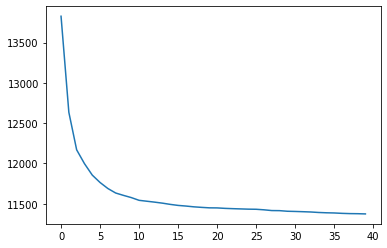

In [ ]:
# Graph to see whether more estimators would help. It seems clear that adding more estimators to the forest would not help accuracy
preds = np.stack([t.predict(valid_xs) for t in rf_model.estimators_])
plt.plot([mean_squared_error(preds[:i+1].mean(0), valid_y, squared=False) for i in range(40)]);

The table below shows which features have the most impact on the model's accuracy. We can see that the 2 engineered features have the most importance.
  
```ContractType``` is at the bottom and not an important feature to the model. This feature is binary and tells us whether a job is full or part time. However it has a huge amount of missing values which is probably why it does not yield much predictive power and can probably be removed without much loss to accuracy.

In [ ]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

fi = rf_feat_importance(rf_model, xs)
fi

,cols,imp
7,job_words,0.256270
6,seniority,0.199424
3,Category,0.156270
5,SourceName,0.133602
4,Company,0.096062
0,LocationNormalized,0.081501
2,ContractTime,0.065240
1,ContractType,0.011631


### Run the model again without the ContractType feature since it has very low feature importance.

### The accuracy of the model actually slightly improves on the validation set after removing this feature

In [ ]:
#collapse-hide
cat_vars = ['LocationNormalized', 'ContractTime', 'Category', 'Company', 'SourceName', 'seniority', 'job_words'] # Removed ContractType
to = TabularPandas(df, procs, cat_vars, y_names = dep_var, splits=splits)
xs, y = to.train.xs, to.train.y
valid_xs, valid_y = to.valid.xs, to.valid.y

rf_model = forest(xs, y);

forest_preds = rf_model.predict(xs)
rf_train_score = mean_absolute_error(y, forest_preds)
valid_preds = rf_model.predict(valid_xs)
rf_valid_score = mean_absolute_error(valid_y, valid_preds)
print('The Feature Engineered Model scored a MAE of {} on the training data and {} on the validation data.'.format(rf_train_score, rf_valid_score))

The Feature Engineered Model scored a MAE of 5755.869472062523 on the training data and 7582.1264663855745 on the validation data.


In [ ]:
fi = rf_feat_importance(rf_model, xs)
fi

,cols,imp
6,job_words,0.258271
5,seniority,0.197063
2,Category,0.155387
4,SourceName,0.142651
3,Company,0.098565
0,LocationNormalized,0.082658
1,ContractTime,0.065404


# Neural Network

### Along with RandomForest, Neural Networks consistently achieve good results on most datasets. 

### Using the fast.ai library I can use the work I have already done cleaning and transforming the data and quickly train a neural net.

In [ ]:
df['SalaryNormalized'] = df['SalaryNormalized'].astype(np.float32)
dls = to.dataloaders(1024)
y = to.train.y
y.min(),y.max()

(5000, 200000)

SuggestedLRs(lr_min=0.33113112449646, lr_steep=0.0008317637839354575)

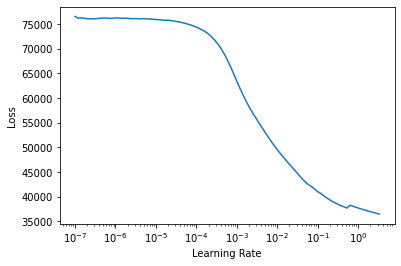

In [ ]:
# Create neural net with MAE as the loss function and find the best learning rate for fitting the model. Picking a learning rate where this curve is steepest is usually the best for training the model.
learn = tabular_learner(dls, y_range=(4900,210000), layers=[500,250],
                        n_out=1, loss_func=mae)
learn.lr_find()

### The neural net scores considerably better than the RandomForest with a MAE of 6,230 compared to 7,625 from the best forest model

In [ ]:
# Fit the model for 10 epochs at a specified learning rate
learn.fit_one_cycle(10, 7e-4)

epoch,train_loss,valid_loss,time
0,12463.211914,8360.904297,00:06
1,7432.699707,7629.067383,00:06
2,6397.468750,7158.133301,00:06
3,5603.918457,6947.498047,00:06
4,4933.529297,6681.348145,00:06
5,4315.979492,6506.173340,00:06
6,3694.033691,6318.576172,00:06
7,3117.943604,6236.548340,00:06
8,2581.269043,6193.021973,00:06
9,2283.618896,6186.819824,00:06


# Ensembling
Lastly I check to see if ensembling the two models will produce better results. By calculating predictions using both models and taking an average, we hope the errors in one model are uncorrelated with the errors in the other and we gain an improvement in the overall performance.

However the ensemble MAE ends up being 6,451.8 compared to the neural net's MAE of 6,186.8. I think the neural network is just too much better than the forest in this case.

In [ ]:
# Take the average of the random forest and neural net predictions
nn_preds, targs = learn.get_preds()
ensemble_preds = (to_np(nn_preds.squeeze()) + valid_preds) /2
mean_absolute_error(valid_y, ensemble_preds)

6451.840949855289

# Conclusion

So on average the best model predicts salaries with an error of 6,186.8 which is a great improvement over the baseline model and has improved by over 2,000 compared to the first model I built.

Considering a lot of jobs will advertise salaries within a band of sometimes $10,000 or greater and that the same job is often advertised at different rates, I think this level of error is pretty good for the task.

### There is potentially room to improve the model further by:


*   Improving the ```seniority``` and ```job_words``` features
*   Looking to mine some useful data from the FullDescription feature
*   Looking at ways to fill missing values in ```ContractType``` and ```ContractTime```
*   Cleaning up the ```LocationNormalized``` feature a bit
*   Testing on more models and potentially ensembling more






